<a href="https://colab.research.google.com/github/rushirajsherlocked/DeepLizard-PyTorch/blob/master/GoogleNet_InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please Refer the Research Paper here: 
[GoogleNet/InceptionNet](https://arxiv.org/pdf/1409.4842.pdf)

In [16]:
import torch
import torch.nn as nn

# How to Code INCEPTION Net??


> The Architecture of Inception Net was created in a lieu to get much deeper convolutional Neural Nets. It Comprises of several "INCEPTION" blocks which use "CONVOLUTIONAL" blocks in turn


> And the whole "GOOGLENET" architecture uses many "INCEPTION" blocks







> ARCHITECTURE FLow: `GOOGLENET ---> INCEPTION blocks ---> CONVOLUTIONAL blocks`







## Coding CONVOLUTIONAL blocks

Follow Bottom - up approach while coding architectures

In [27]:
class conv_blocks(nn.Module):
    def __init__(self, in_channels,out_channels, **kwargs):
        super(conv_blocks,self).__init__()

        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.batchnorm(self.relu(self.conv(x)))



# NOTE: In the original implementation, BATCHNORM layer is after the CONV layer and the normalised activations are passed to RELU
# But I guess that's just the waste of normalised activations so we rather use BATCHNORM last (after RELU) 
# However, if you want to keep the original format, use *** self.relu(self.batchnorm(self.conv(x)))**** in the Forward method

# Coding INCEPTION blocks

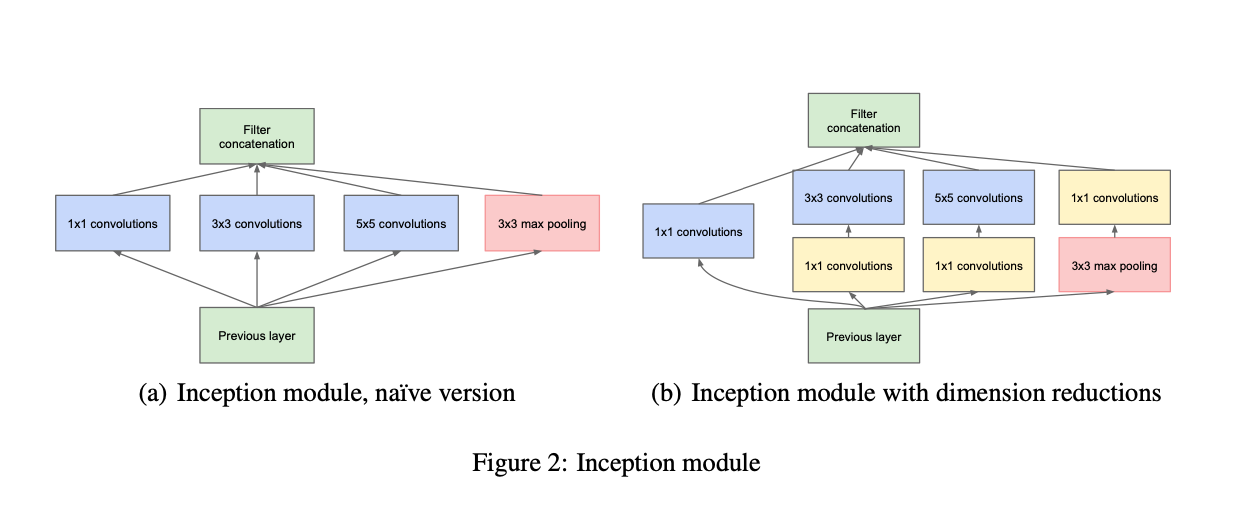

We will implement the Inception module with Dimension Reductions using 1X1 convolutions as it drastically reduces the number of parameters

STEPS:


1.   Notation: 


    *   out_1X1: Refers to the number of outgoing channels after performing
        the first left hand side 1X1 convolution

    *   red_3X3: Refers to the reduced number of channels AFTER performing
         1X1 convolution and BEFORE passing it to 3X3 convolution

    *   out_3X3: Refers to the number of outgoing channels after performing
         3X3 convolutions

    *   out_1x1pool: Refers to the number of outgoing channels after performing
         3X3 Max Pooling
 
      



2.   CONCATENATE all this output channels of the blocks TOGETHER using torch.cat








In [45]:
# NOTE: stride = 1 for all Inception Blocks, Padding = 2 for 5X5 conv and Padding = 1 for 3X3 conv


class Inception_blocks(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_blocks, self).__init__()

        self.branch1 = conv_blocks(in_channels,out_1x1, kernel_size = (1,1))

        self.branch2 = nn.Sequential(
            conv_blocks(in_channels, red_3x3, kernel_size=(1,1)),
            conv_blocks(red_3x3, out_3x3, kernel_size = (3,3), padding = (1,1))
        )

        self.branch3 = nn.Sequential(
            conv_blocks(in_channels, red_5x5, kernel_size = (1,1)),
            conv_blocks(red_5x5, out_5x5, kernel_size = (5,5), padding = (2,2))
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=1, padding = 1),
            conv_blocks(in_channels, out_1x1pool, kernel_size = (1,1))
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)    # dim = 1 ---> (N, C, H, W) 
                                                                                                         # (from 'C' onwards)

# Coding the whole GOOGLENET Architecture

It is a mixture of various CONVOLUTIONAL and INCEPTION blocks

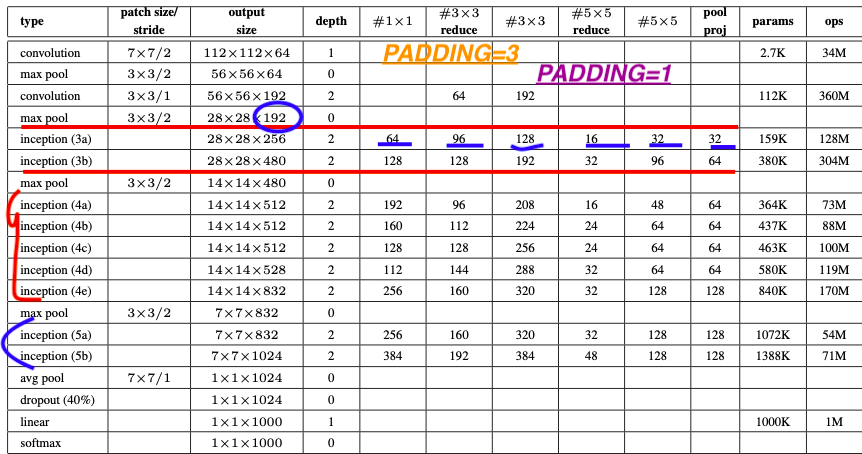

In [55]:
class GoogleNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(GoogleNet, self).__init__()

        self.in_channels = in_channels

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels = 64, kernel_size = (7,7), 
                               stride = (2,2), padding = (3,3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride = 2, padding = 1)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)

        # Include inception blocks now: order - in_channels, out_1x1, red_3x3, out_3x3, red_5X5, out_5X5, out_1X1pool

        self.inception3a = Inception_blocks(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_blocks(256, 128, 128, 192, 32, 96, 64)

        self.maxpool3 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.inception4a = Inception_blocks(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_blocks(512, 160, 112, 224, 24, 64, 64) 
        self.inception4c = Inception_blocks(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_blocks(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_blocks(528, 256, 160, 320, 32, 128, 128 )

        self.maxpool4 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.inception5a = Inception_blocks(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_blocks(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size = 7, stride = 1)
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(1024, 1000) 

    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)

        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)

        x = x.reshape(x.shape[0], -1)     # IMPORTANT: Dont forget to flatten the tensor

        x = self.dropout(x)
        x = self.linear(x)

        return x

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GoogleNet(3, 1000).to(device)
x = torch.rand(2, 3, 224, 224).to(device)

print(model(x).shape)

torch.Size([2, 1000])


In [ ]:

from tensorboardX import SummaryWriter

model = Net1()
with SummaryWriter(comment='Net1') as w:
    w.add_graph(model, (dummy_input, ))